In [ ]:
!. istftnet_env/bin/activate

In [ ]:
import sys
sys.path.append('/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder')

In [ ]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from __future__ import absolute_import, division, print_function, unicode_literals
import argparse
import glob
import os, sys
import json
import torch
from src.utils.utils import AttrDict
from src.datasets.dataset import mel_spectrogram
import soundfile as sf
import numpy as np
import soundfile as sf
import librosa as lib
import time
import tqdm

# инференс

In [ ]:
h = None
device = 'cpu'

def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

def get_mel(h, x):
    return mel_spectrogram(x, h.n_fft, h.num_mels, h.sampling_rate, h.hop_size, h.win_size, h.fmin, h.fmax)

def scan_checkpoint(cp_dir, prefix):
    pattern = os.path.join(cp_dir, prefix + '*')
    cp_list = glob.glob(pattern)
    if len(cp_list) == 0:
        return ''
    return sorted(cp_list)[-1]

def inference(h, model):
    generator = model(h).to(device)

    state_dict_g = load_checkpoint(h.checkpoint_file_load, device)
    generator.load_state_dict(state_dict_g['generator'])

    post_str = os.path.splitext(h.test_input_wavs_dir)[-1]
    if post_str in ['.txt', '.scp']:
        filelist = []
        lines = open(h.test_input_wavs_dir, 'r').readlines()
        for l in lines:
            cur_filename = l.strip().split('/')[1].split('|')[0]
            filelist.append(os.path.join(h.raw_wavfile_path, cur_filename))
    else:  # dir
        filelist = sorted(os.listdir(h.test_input_mels_dir if h.test_mel_load else h.test_input_wavs_dir))

    os.makedirs(h.test_output_dir, exist_ok=True)

    generator.eval()
    try:
        generator.remove_weight_norm()
    except:
        pass
    l = 0
    with torch.no_grad():
        starttime = time.time()
        for filename in tqdm.tqdm(filelist):
            # if h.test_mel_load:
            if h.test_mel_load:
                mel = np.load(os.path.join(h.test_input_wavs_dir, filename))
                x = torch.FloatTensor(mel).to(device)
                x = x.transpose(1,2)
            else:
                if post_str in ['.txt', '.scp']:
                    raw_wav, orig_sr = sf.read(filename)
                else:
                    raw_wav, orig_sr = sf.read(os.path.join(h.test_input_wavs_dir, filename))
                if orig_sr != h.sampling_rate:
                    raw_wav = lib.core.resample(raw_wav, orig_sr=orig_sr, target_sr=h.sampling_rate)

                raw_wav = torch.FloatTensor(raw_wav)
                x = get_mel(h, raw_wav.unsqueeze(0))
            
            y_g_list = generator(x)
            if isinstance(y_g_list, torch.Tensor): 
                y_g = y_g_list
            else:
                y_g = y_g_list[-1]  
            audio = y_g.squeeze()
            audio = audio.cpu().numpy()
            audiolen=len(audio)
            if post_str in ['.txt', '.scp']:
                sf.write(os.path.join(h.test_output_dir, filename.split('/')[-1]), audio, h.sampling_rate, 'PCM_16')
            else:
                sf.write(os.path.join(h.test_output_dir, filename.split('.')[0] + '.wav'), audio, h.sampling_rate, 'PCM_16')

            # print(pp)
            l += audiolen
        end=time.time()
        print(end-starttime)
        print(l/22050)
        print(l/22050/(end-starttime)) 

# hifigan v1

In [ ]:
import sys
sys.path.insert(0,'./pretrained/')

In [ ]:
import os
import argparse
import json
import torch

from pretrained.Models.hifigan import HiFiGAN
from src.utils import utils

def main():
    
    parser = argparse.ArgumentParser(description='Vocoder training configuration')
    
    cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/cfgs/hifigan_v1_config.json'  
    
    with open(cfg_filename, 'r') as f:
        json_config = json.load(f)
    
    h = AttrDict(json_config)
    
    torch.manual_seed(h.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    inference(h, HiFiGAN)

if __name__ == '__main__':
    main()

Using device: cpu
Loading '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/hifigan'
Complete.
Removing weight norm...


100%|██████████| 500/500 [14:54<00:00,  1.79s/it]

894.5425992012024
3273.6072562358277
3.659531987810366


## метрики

## lsd

In [ ]:
from src.metrics.lsd import las_rmse, cal_lsd_wrapper

In [ ]:
ref_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs"
deg_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/HiFiGAN_v1"
sr = 22050  

In [ ]:
def build_ref_dict(ref_dir):
    ref_full_path_dict = {}
    for root, _, files in os.walk(ref_dir):
        for filename in files:
            if filename.endswith(".wav"):
                ref_full_path_dict[filename] = root
    return ref_full_path_dict

ref_dict = build_ref_dict(ref_dir)

mean_lsd, std_lsd = cal_lsd_wrapper(ref_dict, deg_dir, sr=sr)
print(f"Mean LSD score: {mean_lsd:.4f}")
print(f"Standard deviation of LSD: {std_lsd:.4f}")

100%|██████████| 500/500 [00:05<00:00, 88.59it/s]

Mean LSD score: 1.0474
Standard deviation of LSD: 0.0214


## PESQ

In [ ]:
from src.metrics.pesq_ import cal_pesq_wrapper
from glob import glob
import multiprocessing as mp

In [ ]:
gen_files = glob(f"{deg_dir}/*.wav")

# Разбиваем на партиции для многопоточности
num_jobs = 4
file_lists = np.array_split(gen_files, num_jobs)
file_lists = [f_list.tolist() for f_list in file_lists]

# Запуск в процессах
with mp.Manager() as manager:
    pesq_dict = manager.dict()
    processes = []

    for f in file_lists:
        p = mp.Process(target=cal_pesq_wrapper, args=(ref_dict, f, sr, pesq_dict))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    # Обработка результатов
    pesq_scores = list(pesq_dict.values())
    mean_pesq = np.mean(pesq_scores)
    std_pesq = np.std(pesq_scores)

    print(f"PESQ score: mean={mean_pesq:.4f}, std={std_pesq:.4f}")

100%|██████████| 125/125 [00:13<00:00,  9.58it/s]


PESQ score: mean=3.2495, std=0.1690


100%|██████████| 125/125 [00:13<00:00,  9.28it/s]


## FO

In [ ]:
!python /Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/Metrics/evaluate_f0.py\
                --raw_wavdir='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs' \
                --gt_wavdir_or_wavscp='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/descr/test.txt' \
                --gen_wavdir_or_wavscp='/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/HiFiGAN_v1'\
                --outdir='/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/HiFiGAN_v1_fo'


2025-05-18 20:44:40,279 (evaluate_f0:351) INFO: The number of utterances = 500
2025-05-18 20:50:05,517 (evaluate_f0:388) INFO: Average - log_F0-RMSE: 0.1860 ± 0.0846
2025-05-18 20:50:05,517 (evaluate_f0:393) INFO: Average - Semitone_ACC: 55.49%
2025-05-18 20:50:05,518 (evaluate_f0:396) INFO: Average - VUV_ERROR: 11.52%
2025-05-18 20:50:05,546 (evaluate_f0:422) INFO: Successfully finished F0 related evaluation.


In [ ]:
import importlib
import pretrained.Metrics.periodicity_ as periodicity_module

importlib.reload(periodicity_module)

from pretrained.Metrics.periodicity_ import batch_calculate_periodicity

In [ ]:
mean_per, std_per = batch_calculate_periodicity(ref_dict, deg_dir)
print(f"Mean Periodicity score: {mean_per:.4f}")
print(f"Standard deviation of Periodicity: {std_per:.4f}")

  0%|          | 0/500 [00:00<?, ?it/s]

# istftnet

In [ ]:
import os
import argparse
import json
import torch
import tqdm

from pretrained.Models.istftnet import iSTFTNet
from src.utils import utils

def main():
    
    parser = argparse.ArgumentParser(description='Vocoder training configuration')
    
    cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/cfgs/istftnet_config.json'  
    
    with open(cfg_filename, 'r') as f:
        json_config = json.load(f)
    
    h = AttrDict(json_config)
    
    torch.manual_seed(h.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    inference(h, iSTFTNet)

if __name__ == '__main__':
    main()

Using device: cpu
Loading '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/istftnet'
Complete.
Removing weight norm...


100%|██████████| 500/500 [07:19<00:00,  1.14it/s]

439.7062659263611
3273.6072562358277
7.444986596538673


## метрики

## lsd

In [ ]:
from src.metrics.lsd import las_rmse, cal_lsd_wrapper

In [ ]:
ref_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs"
deg_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/ISTftnet_v1"
sr = 22050  

In [ ]:
def build_ref_dict(ref_dir):
    ref_full_path_dict = {}
    for root, _, files in os.walk(ref_dir):
        for filename in files:
            if filename.endswith(".wav"):
                ref_full_path_dict[filename] = root
    return ref_full_path_dict

ref_dict = build_ref_dict(ref_dir)

mean_lsd, std_lsd = cal_lsd_wrapper(ref_dict, deg_dir, sr=sr)
print(f"Mean LSD score: {mean_lsd:.4f}")
print(f"Standard deviation of LSD: {std_lsd:.4f}")

100%|██████████| 500/500 [00:04<00:00, 101.71it/s]

Mean LSD score: 1.0713
Standard deviation of LSD: 0.0205


## PESQ

In [ ]:
from src.metrics.pesq_ import cal_pesq_wrapper
from glob import glob
import multiprocessing as mp

In [ ]:
gen_files = glob(f"{deg_dir}/*.wav")

# Разбиваем на партиции для многопоточности
num_jobs = 4
file_lists = np.array_split(gen_files, num_jobs)
file_lists = [f_list.tolist() for f_list in file_lists]

# Запуск в процессах
with mp.Manager() as manager:
    pesq_dict = manager.dict()
    processes = []

    for f in file_lists:
        p = mp.Process(target=cal_pesq_wrapper, args=(ref_dict, f, sr, pesq_dict))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    # Обработка результатов
    pesq_scores = list(pesq_dict.values())
    mean_pesq = np.mean(pesq_scores)
    std_pesq = np.std(pesq_scores)

    print(f"PESQ score: mean={mean_pesq:.4f}, std={std_pesq:.4f}")

 99%|█████████▉| 124/125 [00:12<00:00,  9.12it/s]

PESQ score: mean=3.2008, std=0.1796


100%|██████████| 125/125 [00:13<00:00,  9.56it/s]


## FO

In [ ]:
!python /Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/Metrics/evaluate_f0.py\
                --raw_wavdir='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs' \
                --gt_wavdir_or_wavscp='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/descr/test.txt' \
                --gen_wavdir_or_wavscp='/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/ISTftnet_v1'\
                --outdir='/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/ISTftnet_v1'


2025-05-18 21:01:30,400 (evaluate_f0:351) INFO: The number of utterances = 500
2025-05-18 21:07:19,115 (evaluate_f0:388) INFO: Average - log_F0-RMSE: 0.1906 ± 0.0878
2025-05-18 21:07:19,115 (evaluate_f0:393) INFO: Average - Semitone_ACC: 54.70%
2025-05-18 21:07:19,115 (evaluate_f0:396) INFO: Average - VUV_ERROR: 11.67%
2025-05-18 21:07:19,144 (evaluate_f0:422) INFO: Successfully finished F0 related evaluation.


# freev

In [ ]:
import os
import argparse
import json
import torch
import tqdm

from pretrained.Models.freeV import FreeV
from src.utils import utils

def main():
    
    parser = argparse.ArgumentParser(description='Vocoder training configuration')
    
    cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/cfgs/freev_config.json'  
    
    with open(cfg_filename, 'r') as f:
        json_config = json.load(f)
    
    h = AttrDict(json_config)
    
    torch.manual_seed(h.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    inference(h, FreeV)

if __name__ == '__main__':
    main()

Using device: cpu
Loading '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/freev'
Complete.



00%|██████████| 500/500 [00:43<00:00, 11.62it/s]

43.030747175216675
3267.802267573696
75.94109984350374


## метрики

## lsd

In [ ]:
from src.metrics.lsd import las_rmse, cal_lsd_wrapper

In [ ]:
ref_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs"
deg_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/freev_v1"
sr = 22050  

In [ ]:
def build_ref_dict(ref_dir):
    ref_full_path_dict = {}
    for root, _, files in os.walk(ref_dir):
        for filename in files:
            if filename.endswith(".wav"):
                ref_full_path_dict[filename] = root
    return ref_full_path_dict

ref_dict = build_ref_dict(ref_dir)

mean_lsd, std_lsd = cal_lsd_wrapper(ref_dict, deg_dir, sr=sr)
print(f"Mean LSD score: {mean_lsd:.4f}")
print(f"Standard deviation of LSD: {std_lsd:.4f}")

100%|██████████| 500/500 [00:05<00:00, 97.15it/s] 

Mean LSD score: 0.8764
Standard deviation of LSD: 0.0206


## PESQ

In [ ]:
from src.metrics.pesq_ import cal_pesq_wrapper
from glob import glob
import multiprocessing as mp

In [ ]:
gen_files = glob(f"{deg_dir}/*.wav")

# Разбиваем на партиции для многопоточности
num_jobs = 4
file_lists = np.array_split(gen_files, num_jobs)
file_lists = [f_list.tolist() for f_list in file_lists]

# Запуск в процессах
with mp.Manager() as manager:
    pesq_dict = manager.dict()
    processes = []

    for f in file_lists:
        p = mp.Process(target=cal_pesq_wrapper, args=(ref_dict, f, sr, pesq_dict))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    # Обработка результатов
    pesq_scores = list(pesq_dict.values())
    mean_pesq = np.mean(pesq_scores)
    std_pesq = np.std(pesq_scores)

    print(f"PESQ score: mean={mean_pesq:.4f}, std={std_pesq:.4f}")

 98%|█████████▊| 123/125 [00:15<00:00,  9.33it/s]

PESQ score: mean=3.1185, std=0.1880


100%|██████████| 125/125 [00:15<00:00,  8.26it/s]


## FO

In [ ]:
!python /Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/Metrics/evaluate_f0.py\
                --raw_wavdir='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs' \
                --gt_wavdir_or_wavscp='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/descr/test.txt' \
                --gen_wavdir_or_wavscp='/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/freev_v1'\
                --outdir='/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/freev_v1'


2025-05-18 21:10:27,511 (evaluate_f0:351) INFO: The number of utterances = 500
2025-05-18 21:16:16,132 (evaluate_f0:388) INFO: Average - log_F0-RMSE: 0.2077 ± 0.0912
2025-05-18 21:16:16,132 (evaluate_f0:393) INFO: Average - Semitone_ACC: 62.63%
2025-05-18 21:16:16,132 (evaluate_f0:396) INFO: Average - VUV_ERROR: 11.59%
2025-05-18 21:16:16,162 (evaluate_f0:422) INFO: Successfully finished F0 related evaluation.


# baseline

In [ ]:
import os
import argparse
import json
import torch
import tqdm

from src.model.model_fin import Generator
from src.utils import utils

def main():
    
    parser = argparse.ArgumentParser(description='Vocoder training configuration')
    
    cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/src/configs/model_fin.json'  
    
    with open(cfg_filename, 'r') as f:
        json_config = json.load(f)
    
    h = AttrDict(json_config)
    
    torch.manual_seed(h.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    inference(h, Generator)

if __name__ == '__main__':
    main()

Initializing Training Process...
Using device: cpu
Loading '/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/cp_model_v2/g_00050000'
Complete.
Removing weight norm...


100%|██████████| 500/500 [06:26<00:00,  1.29it/s]

386.97406005859375
3273.6072562358277
8.459500504349448


## метрики

## lsd

In [ ]:
from src.metrics.lsd import las_rmse, cal_lsd_wrapper

In [ ]:
ref_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs"
deg_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/output_fin"
sr = 22050  

In [ ]:
def build_ref_dict(ref_dir):
    ref_full_path_dict = {}
    for root, _, files in os.walk(ref_dir):
        for filename in files:
            if filename.endswith(".wav"):
                ref_full_path_dict[filename] = root
    return ref_full_path_dict

ref_dict = build_ref_dict(ref_dir)

mean_lsd, std_lsd = cal_lsd_wrapper(ref_dict, deg_dir, sr=sr)
print(f"Mean LSD score: {mean_lsd:.4f}")
print(f"Standard deviation of LSD: {std_lsd:.4f}")

100%|██████████| 500/500 [00:04<00:00, 108.77it/s]

Mean LSD score: 0.9900
Standard deviation of LSD: 0.0247


## PESQ

In [ ]:
from src.metrics.pesq_ import cal_pesq_wrapper
from glob import glob
import multiprocessing as mp

In [ ]:
gen_files = glob(f"{deg_dir}/*.wav")

# Разбиваем на партиции для многопоточности
num_jobs = 4
file_lists = np.array_split(gen_files, num_jobs)
file_lists = [f_list.tolist() for f_list in file_lists]

# Запуск в процессах
with mp.Manager() as manager:
    pesq_dict = manager.dict()
    processes = []

    for f in file_lists:
        p = mp.Process(target=cal_pesq_wrapper, args=(ref_dict, f, sr, pesq_dict))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    # Обработка результатов
    pesq_scores = list(pesq_dict.values())
    mean_pesq = np.mean(pesq_scores)
    std_pesq = np.std(pesq_scores)

    print(f"PESQ score: mean={mean_pesq:.4f}, std={std_pesq:.4f}")

100%|██████████| 125/125 [00:13<00:00,  9.30it/s]


PESQ score: mean=3.2313, std=0.1825


100%|██████████| 125/125 [00:13<00:00,  8.96it/s]


## FO

In [ ]:
!python /Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/Metrics/evaluate_f0.py\
                --raw_wavdir='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs' \
                --gt_wavdir_or_wavscp='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/descr/test.txt' \
                --gen_wavdir_or_wavscp="/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/output_fin"\
                --outdir="/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/output_fin"


2025-05-18 21:49:18,562 (evaluate_f0:351) INFO: The number of utterances = 500
2025-05-18 21:54:41,599 (evaluate_f0:388) INFO: Average - log_F0-RMSE: 0.2087 ± 0.0887
2025-05-18 21:54:41,600 (evaluate_f0:393) INFO: Average - Semitone_ACC: 57.43%
2025-05-18 21:54:41,600 (evaluate_f0:396) INFO: Average - VUV_ERROR: 12.44%
2025-05-18 21:54:41,633 (evaluate_f0:422) INFO: Successfully finished F0 related evaluation.


# hifigan v2

In [ ]:
import os
import argparse
import json
import torch
import tqdm

from pretrained.Models.hifigan import HiFiGAN
from src.utils import utils

def main():
    
    parser = argparse.ArgumentParser(description='Vocoder training configuration')
    
    cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/cfgs/config.json'  
    
    with open(cfg_filename, 'r') as f:
        json_config = json.load(f)
    
    h = AttrDict(json_config)
    
    torch.manual_seed(h.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    inference(h, HiFiGAN)

if __name__ == '__main__':
    main()

Using device: cpu
Loading '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/generator_v2'
Complete.
Removing weight norm...


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]

179.1493899822235
3273.6072562358277
18.273058348458


## метрики

## lsd

In [ ]:
from src.metrics.lsd import las_rmse, cal_lsd_wrapper

In [ ]:
ref_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs"
deg_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/hifigan_v2"
sr = 22050  

In [ ]:
def build_ref_dict(ref_dir):
    ref_full_path_dict = {}
    for root, _, files in os.walk(ref_dir):
        for filename in files:
            if filename.endswith(".wav"):
                ref_full_path_dict[filename] = root
    return ref_full_path_dict

ref_dict = build_ref_dict(ref_dir)

mean_lsd, std_lsd = cal_lsd_wrapper(ref_dict, deg_dir, sr=sr)
print(f"Mean LSD score: {mean_lsd:.4f}")
print(f"Standard deviation of LSD: {std_lsd:.4f}")

100%|██████████| 500/500 [00:05<00:00, 87.12it/s]

Mean LSD score: 1.1007
Standard deviation of LSD: 0.0242


## PESQ

In [ ]:
from src.metrics.pesq_ import cal_pesq_wrapper
from glob import glob
import multiprocessing as mp

In [ ]:
gen_files = glob(f"{deg_dir}/*.wav")

# Разбиваем на партиции для многопоточности
num_jobs = 4
file_lists = np.array_split(gen_files, num_jobs)
file_lists = [f_list.tolist() for f_list in file_lists]

# Запуск в процессах
with mp.Manager() as manager:
    pesq_dict = manager.dict()
    processes = []

    for f in file_lists:
        p = mp.Process(target=cal_pesq_wrapper, args=(ref_dict, f, sr, pesq_dict))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    # Обработка результатов
    pesq_scores = list(pesq_dict.values())
    mean_pesq = np.mean(pesq_scores)
    std_pesq = np.std(pesq_scores)

    print(f"PESQ score: mean={mean_pesq:.4f}, std={std_pesq:.4f}")

 99%|█████████▉| 124/125 [00:16<00:00,  9.56it/s]

PESQ score: mean=2.6913, std=0.1795


100%|██████████| 125/125 [00:16<00:00,  7.61it/s]


## FO

In [ ]:
!python /Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/Metrics/evaluate_f0.py\
                --raw_wavdir='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs' \
                --gt_wavdir_or_wavscp='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/descr/test.txt' \
                --gen_wavdir_or_wavscp='/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/hifigan_v2'\
                --outdir='/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/hifigan_v2'


2025-05-18 22:14:44,039 (evaluate_f0:351) INFO: The number of utterances = 500
2025-05-18 22:20:07,968 (evaluate_f0:388) INFO: Average - log_F0-RMSE: 0.1911 ± 0.0889
2025-05-18 22:20:07,968 (evaluate_f0:393) INFO: Average - Semitone_ACC: 53.21%
2025-05-18 22:20:07,968 (evaluate_f0:396) INFO: Average - VUV_ERROR: 12.12%
2025-05-18 22:20:07,997 (evaluate_f0:422) INFO: Successfully finished F0 related evaluation.


# vocos

In [ ]:
sys.path.append('/Users/liliyaivannikova/Documents/vkr/pytorch_project/vocos/')

In [ ]:
from vocos.pretrained import Vocos

def instantiate_class(args, init):
    kwargs = init.get("init_args", {})
    if not isinstance(args, tuple):
        args = (args,)
    class_module, class_name = init["class_path"].rsplit(".", 1)
    module = __import__(class_module, fromlist=[class_name])
    args_class = getattr(module, class_name)
    return args_class(*args, **kwargs)

def from_hparams(config_path: str):
        """
        Class method to create a new Vocos model instance from hyperparameters stored in a yaml configuration file.
        """
        with open(config_path, "r") as f:
            config = yaml.safe_load(f)

        feature_extractor = instantiate_class(args=(), init=config["feature_extractor"])
        backbone = instantiate_class(args=(), init=config["backbone"])
        head = instantiate_class(args=(), init=config["head"])
        
        model = Vocos(feature_extractor,
                         backbone,
                         head
                         )
        return model

def from_pretrained():
        
        config_path = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/vocos/configs/vocos.yaml'
        model_path = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/vocos/vocos.ckpt'
        model = from_hparams(config_path)
        state_dict = torch.load(model_path, map_location="cpu")
    
        model.eval()
        return model

In [ ]:
import torchaudio

In [ ]:
def inference_vocos(h):
 
    generator = from_pretrained()

    post_str = os.path.splitext(h.test_input_wavs_dir)[-1]
    if post_str in ['.txt', '.scp']:
        filelist = []
        lines = open(h.test_input_wavs_dir, 'r').readlines()
        for l in lines:
            cur_filename = l.strip().split('/')[1].split('|')[0]
            filelist.append(os.path.join(h.raw_wavfile_path, cur_filename))
    else:  # dir
        filelist = sorted(os.listdir(h.test_input_mels_dir if h.test_mel_load else h.test_input_wavs_dir))

    os.makedirs(h.test_output_dir, exist_ok=True)

    generator.eval()
    try:
        generator.remove_weight_norm()
    except:
        pass
    l = 0
    with torch.no_grad():
        starttime = time.time()
        for filename in tqdm.tqdm(filelist):
            # if h.test_mel_load:
            if h.test_mel_load:
                mel = np.load(os.path.join(h.test_input_wavs_dir, filename))
                x = torch.FloatTensor(mel).to(device)
                x = x.transpose(1,2)
            else:
                if post_str in ['.txt', '.scp']:
                    raw_wav, orig_sr = sf.read(filename)
                else:
                    raw_wav, orig_sr = sf.read(os.path.join(h.test_input_wavs_dir, filename))
                if orig_sr != h.sampling_rate:
                    raw_wav = lib.core.resample(raw_wav, orig_sr=orig_sr, target_sr=h.sampling_rate)

                raw_wav = torch.FloatTensor(raw_wav)
                mel_spec = torchaudio.transforms.MelSpectrogram(
                                                                        sample_rate=22050,
                                                                        n_fft=1024,
                                                                        hop_length=256,
                                                                        n_mels=100,
                                                                        center= "center",
                                                                        power=1,
                                                                    )
                
                x = mel_spec(raw_wav.unsqueeze(0))
                x = torch.log(torch.clip(x, min=1e-7))
                
            # y_g_list = vocos.decode(x)
            y_g_list = vocos(raw_wav.unsqueeze(0))
            if isinstance(y_g_list, torch.Tensor): 
                y_g = y_g_list
            else:
                y_g = y_g_list[-1]  
            audio = y_g.squeeze()
            audio = audio.cpu().numpy()
            audiolen=len(audio)
            if post_str in ['.txt', '.scp']:
                sf.write(os.path.join(h.test_output_dir, filename.split('/')[-1]), audio, h.sampling_rate, 'PCM_16')
            else:
                sf.write(os.path.join(h.test_output_dir, filename.split('.')[0] + '.wav'), audio, h.sampling_rate, 'PCM_16')

            # print(pp)
            l += audiolen
        end=time.time()
        print(end-starttime)
        print(l/22050)
        print(l/22050/(end-starttime)) 

In [ ]:
import os
import argparse
import json
import torch
import tqdm

from src.utils import utils

def main():
    
    parser = argparse.ArgumentParser(description='Vocoder training configuration')
    
    cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/vocos/configs/vocos_inf.json'  
    
    with open(cfg_filename, 'r') as f:
        json_config = json.load(f)
    
    h = AttrDict(json_config)
    
    torch.manual_seed(h.seed_everything)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    inference_vocos(h)

if __name__ == '__main__':
    main()

Using device: cpu


100%|██████████| 500/500 [00:32<00:00, 15.25it/s]

32.79685688018799
3267.802267573696
99.63766587485762


## метрики

## lsd

In [ ]:
from src.metrics.lsd import las_rmse, cal_lsd_wrapper

In [ ]:
ref_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs"
deg_dir = "/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/vocos"
sr = 22050

In [ ]:
def build_ref_dict(ref_dir):
    ref_full_path_dict = {}
    for root, _, files in os.walk(ref_dir):
        for filename in files:
            if filename.endswith(".wav"):
                ref_full_path_dict[filename] = root
    return ref_full_path_dict

ref_dict = build_ref_dict(ref_dir)

mean_lsd, std_lsd = cal_lsd_wrapper(ref_dict, deg_dir, sr=sr)


print(f"Mean LSD score: {mean_lsd:.4f}")
print(f"Standard deviation of LSD: {std_lsd:.4f}")

100%|██████████| 500/500 [00:05<00:00, 95.65it/s] 

Mean LSD score: 1.2106
Standard deviation of LSD: 0.0816


## PESQ

In [ ]:
from src.metrics.pesq_ import cal_pesq_wrapper
from glob import glob
import multiprocessing as mp

In [ ]:
gen_files = glob(f"{deg_dir}/*.wav")

# Разбиваем на партиции для многопоточности
num_jobs = 4
file_lists = np.array_split(gen_files, num_jobs)
file_lists = [f_list.tolist() for f_list in file_lists]

# Запуск в процессах
with mp.Manager() as manager:
    pesq_dict = manager.dict()
    processes = []

    for f in file_lists:
        p = mp.Process(target=cal_pesq_wrapper, args=(ref_dict, f, sr, pesq_dict))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    # Обработка результатов
    pesq_scores = list(pesq_dict.values())
    mean_pesq = np.mean(pesq_scores)
    std_pesq = np.std(pesq_scores)

    print(f"PESQ score: mean={mean_pesq:.4f}, std={std_pesq:.4f}")

100%|██████████| 125/125 [00:15<00:00,  8.29it/s]


PESQ score: mean=3.4970, std=0.1646


## FO

In [ ]:
!python /Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/Metrics/evaluate_f0.py\
                --raw_wavdir='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/wavs' \
                --gt_wavdir_or_wavscp='/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/data/descr/test.txt' \
                --gen_wavdir_or_wavscp='/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/vocos'\
                --outdir='/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/pretrained/vocos'


2025-05-20 23:13:30,430 (evaluate_f0:351) INFO: The number of utterances = 500
2025-05-20 23:18:58,670 (evaluate_f0:388) INFO: Average - log_F0-RMSE: 0.1820 ± 0.0845
2025-05-20 23:18:58,670 (evaluate_f0:393) INFO: Average - Semitone_ACC: 63.87%
2025-05-20 23:18:58,670 (evaluate_f0:396) INFO: Average - VUV_ERROR: 11.55%
2025-05-20 23:18:58,700 (evaluate_f0:422) INFO: Successfully finished F0 related evaluation.


## maag

In [ ]:
# !pip install thop

In [ ]:
from thop import profile

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 22050
t = np.linspace(0, 1, sample_rate, endpoint=False)
signal = np.sin(2 * np.pi * 440 * t)

mel_spectrogram = librosa.feature.melspectrogram(y=signal, 
                                                 sr=sample_rate, 
                                                 n_fft=1024, 
                                                 hop_length=256,
                                                 n_mels=80)

mel_tensor = torch.tensor(mel_spectrogram).float().unsqueeze(0) 

In [ ]:
cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/cfgs/config.json'  
    
with open(cfg_filename, 'r') as f:
    json_config = json.load(f)
    
h = AttrDict(json_config)

model = HiFiGAN(h).eval()

macs, params = profile(model, inputs=(mel_tensor,))

print(f"MACs: {macs}, Parameters: {params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose1d'>.
MACs: 1931784192.0, Parameters: 928514.0


In [ ]:
from pretrained.Models.hifigan import HiFiGAN

cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/cfgs/hifigan_v1_config.json'  
  
with open(cfg_filename, 'r') as f:
    json_config = json.load(f)
    
h = AttrDict(json_config)

model = HiFiGAN(h).eval()

macs, params = profile(model, inputs=(mel_tensor,))

print(f"MACs: {macs}, Parameters: {params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose1d'>.
MACs: 30818746368.0, Parameters: 13936130.0


In [ ]:
cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/cfgs/istftnet_config.json'  
    
with open(cfg_filename, 'r') as f:
    json_config = json.load(f)
    
h = AttrDict(json_config)

model = iSTFTNet(h).eval()

macs, params = profile(model, inputs=(mel_tensor,))

print(f"MACs: {macs}, Parameters: {params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose1d'>.
MACs: 21735350016.0, Parameters: 13262244.0


In [ ]:
cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/research/istftnet/pretrained/cfgs/freev_config.json'  
    
with open(cfg_filename, 'r') as f:
    json_config = json.load(f)
    
h = AttrDict(json_config)

model = FreeV(h).eval()

macs, params = profile(model, inputs=(mel_tensor, ))

print(f"MACs: {macs}, Parameters: {params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MACs: 1581446589.0, Parameters: 18190861.0


In [ ]:
cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/src/configs/model_fin.json'  
    
with open(cfg_filename, 'r') as f:
    json_config = json.load(f)
    
h = AttrDict(json_config)

model = Generator(h).eval()

macs, params = profile(model, inputs=(mel_tensor, ))

print(f"MACs: {macs}, Parameters: {params}")

[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
MACs: 2550692913.0, Parameters: 5638572.0


In [ ]:
sys.path.append('/Users/liliyaivannikova/Documents/vkr/pytorch_project/vocos/')

In [ ]:
# !pip install pytorch_lightning==1.8.6

In [ ]:
from vocos.pretrained import Vocos
from vocos.feature_extractors import MelSpectrogramFeatures
from vocos.models import VocosBackbone
from vocos.heads import ISTFTHead
import yaml

cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/vocos/configs/vocos.json'  

with open(cfg_filename, 'r') as f:
    json_config = json.load(f)
    
model_init_args = json_config["model"]["init_args"]

# Извлекаем подконфиги
feature_extractor_cfg = model_init_args.pop("feature_extractor")
backbone_cfg = model_init_args.pop("backbone")
head_cfg = model_init_args.pop("head")

# Создаём компоненты
feature_extractor = MelSpectrogramFeatures(**feature_extractor_cfg['init_args'])
backbone = VocosBackbone(**backbone_cfg['init_args'])
head = ISTFTHead(**head_cfg['init_args'])

In [ ]:
model = Vocos(feature_extractor=feature_extractor,
                backbone=backbone,
                head=head,).eval()

class DecodeWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model.decode(x)

wrapper = DecodeWrapper(model)

macs, params = profile(wrapper, inputs=(mel_tensor,))

print(f"MACs: {macs}, Parameters: {params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MACs: 1169636352.0, Parameters: 13455874.0


## лчм

In [ ]:
%matplotlib inline

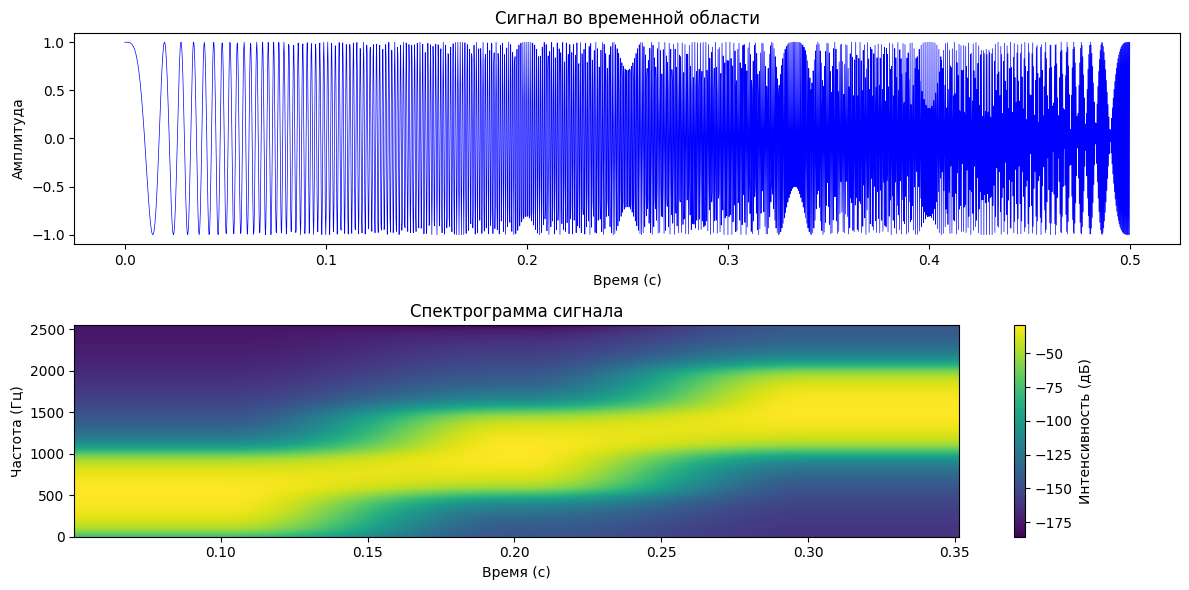

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp

# Параметры сигнала
duration = 0.5          # Длительность сигнала (с)
sample_rate = 5100     # Частота дискретизации (Гц)
num_samples = int(sample_rate * duration)

# Генерация ЛЧМ-сигнала (линейная частотная модуляция)
t = np.linspace(0, duration, num_samples, endpoint=False)
f_start = 0             # Начальная частота (Гц)
f_end = sample_rate / 2 # Конечная частота (до частоты Найквиста)
wideband_signal = chirp(t, f_start, duration, f_end, method='linear')

# Построение временного графика сигнала
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, wideband_signal, color='blue', linewidth=0.5)
plt.title("Сигнал во временной области")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")

# Построение спектрограммы
plt.subplot(2, 1, 2)
plt.specgram(wideband_signal, NFFT=1024, Fs=sample_rate, noverlap=512, cmap='viridis')
plt.title("Спектрограмма сигнала")
plt.xlabel("Время (с)")
plt.ylabel("Частота (Гц)")
plt.colorbar(label="Интенсивность (дБ)")

plt.tight_layout()
plt.show()

In [ ]:
import os
import argparse
import json
import torch

from src.model.model_fin import ConvNeXtBlock


In [ ]:
parser = argparse.ArgumentParser(description='Vocoder training configuration')
    
cfg_filename = '/Users/liliyaivannikova/Documents/vkr/pytorch_project/audio_vocoder/src/configs/model_fin.json'  
    
with open(cfg_filename, 'r') as f:
        json_config = json.load(f)
    
h = AttrDict(json_config)

In [ ]:
model = ConvNeXtBlock(
    dim=h.ASP_channel, 
    intermediate_dim=1536, 
    layer_scale_init_value=1 / 8, 
    adanorm_num_embeddings=None
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = Generator(h)
print(f"Total trainable parameters: {count_parameters(model):,}")

Total trainable parameters: 1,586,187
